In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json

In [2]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
feature_detection_method = 'pasef'

EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
IDENTIFICATIONS_DIR = '{}/identifications-{}'.format(EXPERIMENT_DIR, feature_detection_method)
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_no_correction_df = d['identifications_df']

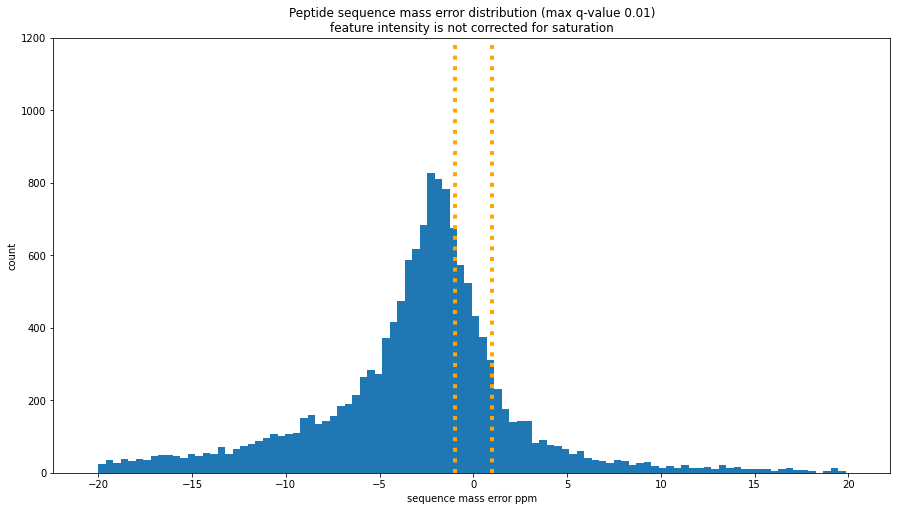

In [9]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(identifications_no_correction_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### with correction for saturation

In [5]:
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_correction_df = d['identifications_df']

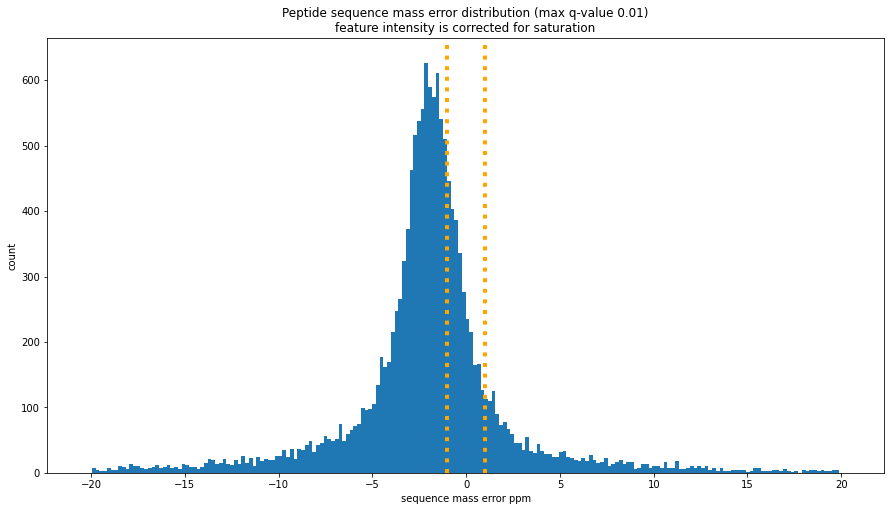

In [8]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 200
hist, bins, _ = plt.hist(identifications_with_correction_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.xlim((-20,20))
# plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### dynamic range comparison

In [9]:
identifications_with_correction_df.columns

Index(['monoisotopic_mz', 'charge', 'monoisotopic_mass', 'feature_intensity',
       'envelope_mono_peak_mz', 'envelope_mono_peak_intensity', 'envelope',
       'isotope_count', 'deconvolution_score', 'scan_apex', 'scan_lower',
       'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper',
       'mono_mz_without_saturated_points', 'mono_intensity_from_raw_points',
       'mono_intensity_adjustment_outcome',
       'isotopic_peak_intensities_from_raw_points', 'precursor_cuboid_id',
       'fragment_ions_l', 'feature_id', 'run_name', 'file_idx',
       'spectrum precursor m/z', 'spectrum neutral mass', 'peptide mass',
       'percolator score', 'percolator q-value', 'percolator PEP',
       'total matches/spectrum', 'sequence', 'protein id', 'flanking aa',
       'observed_monoisotopic_mass', 'theoretical_peptide_mass',
       'mass_accuracy_ppm', 'mass_error'],
      dtype='object')

In [14]:
identifications_with_correction_df.mono_intensity_adjustment_outcome.value_counts()


monoisotopic_not_saturated         13497
monoisotopic_saturated_adjusted      726
no_nonsaturated_isotopes              12
Name: mono_intensity_adjustment_outcome, dtype: int64

In [15]:
df = identifications_with_correction_df[identifications_with_correction_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted']

In [21]:
df.iloc[0].isotopic_peak_intensities_from_raw_points

[{'intensity': 1742298,
  'saturated': True,
  'inferred_intensity': 1769943,
  'inferred': True},
 {'intensity': 1037501,
  'saturated': True,
  'inferred_intensity': 1062254,
  'inferred': True},
 {'intensity': 372176,
  'saturated': False,
  'inferred_intensity': 372176,
  'inferred': False}]

In [24]:
adjusted_features_l = []
for idx,row in enumerate(df.itertuples()):
    unadjusted_intensity = row.isotopic_peak_intensities_from_raw_points[0]['intensity']
    adjusted_features_l.append({'intensity':unadjusted_intensity, 'method':'unadjusted'})
    adjusted_intensity = row.isotopic_peak_intensities_from_raw_points[0]['inferred_intensity']
    adjusted_features_l.append({'intensity':adjusted_intensity, 'method':'adjusted'})
adjusted_features_df = pd.DataFrame(adjusted_features_l)
adjusted_features_df['intensity_log'] = np.log10(adjusted_features_df.intensity)

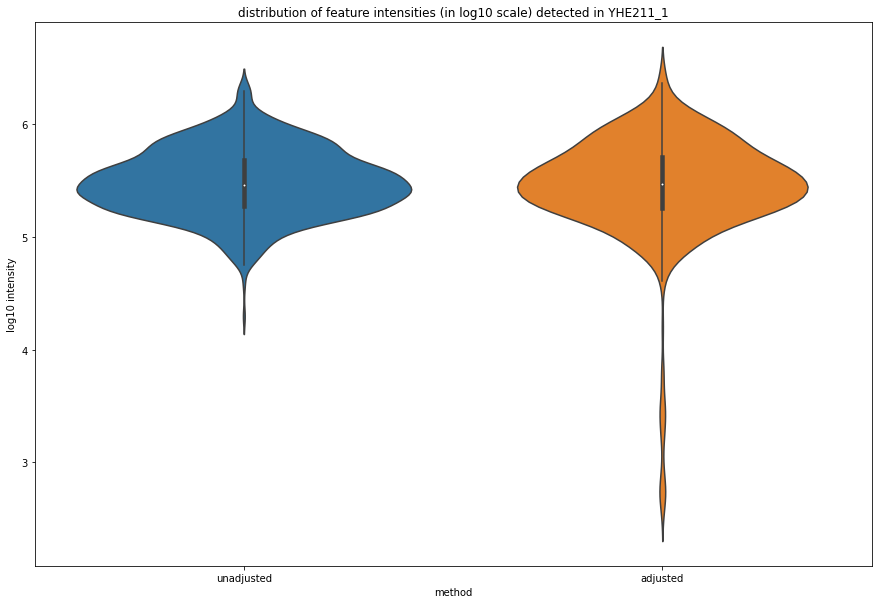

In [25]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=adjusted_features_df.method, y=adjusted_features_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')